<a href="https://colab.research.google.com/github/arinjay-singh/econ3916-statistical-machine-learning/blob/main/Class%202/class2_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import userdata
import os

api_key = userdata.get("FRED_API_KEY")
# print(f"API Key: {api_key}")

In [5]:
# install the FRED API library
!pip install fredapi

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key=api_key)

In [7]:
# fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# drop missing values (The wage data starts later than CPI data)
df = df.dropna()

Fetching data from FRED...


In [8]:
df.head(10)

,Nominal_Wage,CPI
1964-01-01,2.50,30.94
1964-02-01,2.50,30.91
1964-03-01,2.51,30.94
1964-04-01,2.52,30.95
1964-05-01,2.52,30.98
1964-06-01,2.53,31.01
1964-07-01,2.54,31.02
1964-08-01,2.55,31.05
1964-09-01,2.56,31.08
1964-10-01,2.55,31.12


In [9]:
df.tail(10)

,Nominal_Wage,CPI
2025-02-01,30.91,319.775
2025-03-01,30.97,319.615
2025-04-01,31.05,320.321
2025-05-01,31.14,320.580
2025-06-01,31.26,321.500
2025-07-01,31.35,322.132
2025-08-01,31.45,323.364
2025-09-01,31.52,324.368
2025-11-01,31.73,325.031
2025-12-01,31.76,326.030


In [10]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


## Comparing Nominal vs Real Wages

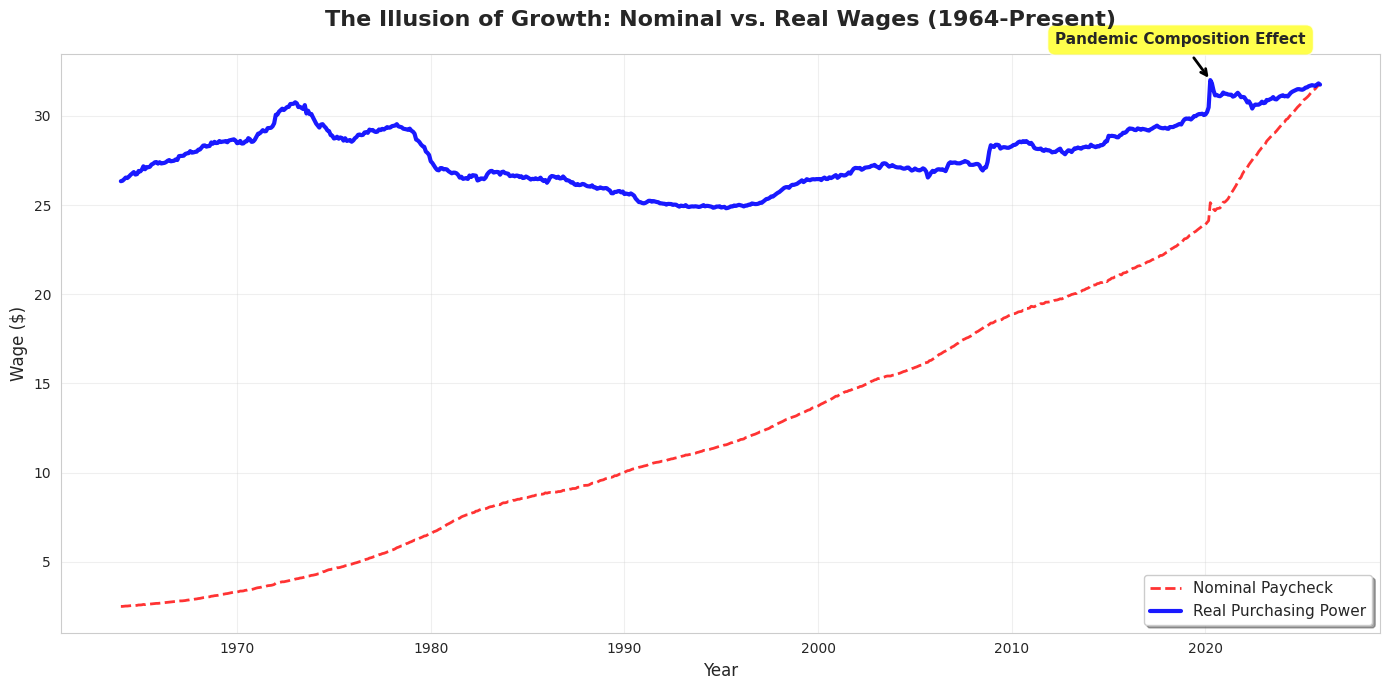

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot both wage series
plt.plot(df.index, df['Nominal_Wage'],
         linestyle='--', color='red', linewidth=2,
         label='Nominal Paycheck', alpha=0.8)

plt.plot(df.index, df['Real_Wage'],
         linestyle='-', color='blue', linewidth=3,
         label='Real Purchasing Power', alpha=0.9)

# Title and labels
plt.title('The Illusion of Growth: Nominal vs. Real Wages (1964-Present)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Wage ($)', fontsize=12)

# Add annotation for 2020 pandemic spike
# Find 2020 data point
spike_date = '2020'
spike_value = df.loc[df.index.year == 2020, 'Real_Wage'].max()
spike_idx = df[df.index.year == 2020]['Real_Wage'].idxmax()

plt.annotate('Pandemic Composition Effect',
             xy=(spike_idx, spike_value),
             xytext=(spike_idx - pd.DateOffset(years=8), spike_value + 2),
             arrowprops=dict(arrowstyle='->', color='black', lw=2),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Legend and grid
plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Employment Cost Index Correction

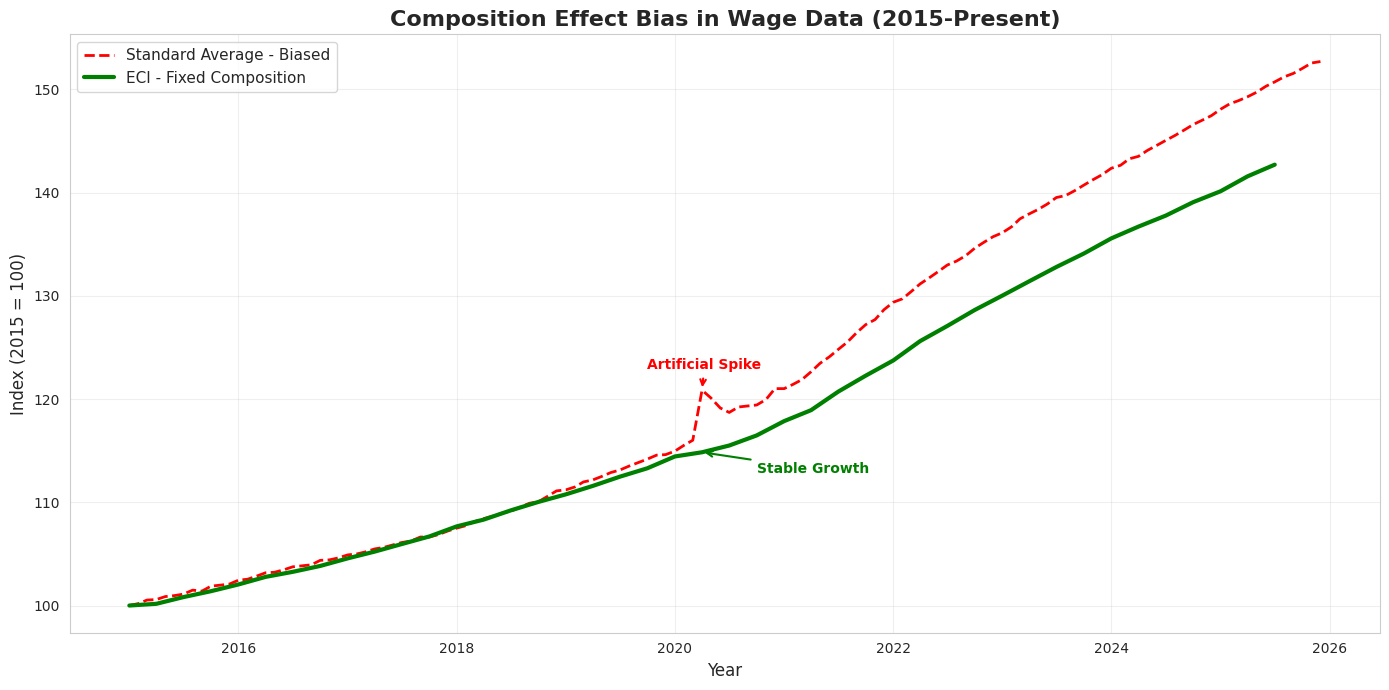

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch Employment Cost Index
eci = fred.get_series('ECIWAG')

# Filter both series to 2015 onwards
wages_filtered = wages[wages.index >= '2015-01-01']
eci_filtered = eci[eci.index >= '2015-01-01']

# Rebase both to 100
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# Create plot
plt.figure(figsize=(14, 7))

# Plot both series
plt.plot(wages_rebased.index, wages_rebased,
         linestyle='--', color='red', linewidth=2,
         label='Standard Average - Biased')

plt.plot(eci_rebased.index, eci_rebased,
         linestyle='-', color='green', linewidth=3,
         label='ECI - Fixed Composition')

# Title and labels
plt.title('Composition Effect Bias in Wage Data (2015-Present)',
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index (2015 = 100)', fontsize=12)

# Find the ACTUAL 2020 spike (should be Q2 2020 - April/May timeframe)
wages_2020 = wages_rebased[(wages_rebased.index >= '2020-03-01') &
                            (wages_rebased.index <= '2020-06-30')]
spike_date_wages = wages_2020.idxmax()
spike_value = wages_rebased.loc[spike_date_wages]

# Find closest ECI date
eci_2020 = eci_rebased[eci_rebased.index.year == 2020]
spike_date_eci = eci_2020.index[eci_2020.index.get_indexer([spike_date_wages], method='nearest')[0]]
eci_value = eci_rebased.loc[spike_date_eci]

# Annotate artificial spike in Q2 2020
plt.annotate('Artificial Spike',
             xy=(spike_date_wages, spike_value),
             xytext=(spike_date_wages - pd.DateOffset(months=6), spike_value + 2),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')

# Annotate stable growth at same timeframe
plt.annotate('Stable Growth',
             xy=(spike_date_eci, eci_value),
             xytext=(spike_date_eci + pd.DateOffset(months=6), eci_value - 2),
             arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
             fontsize=10, color='green', fontweight='bold')

# Legend and grid
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()